# Quantum State Tomography

This notebook contains a first introduction to quantum state tomography. Before anything let's make sure we have the necessary tools to write some code:

In [1]:
import numpy as np
import random as rd
from qiskit.visualization import *
from qiskit import *
import qiskit.tools.jupyter
from jupyterthemes import jtplot
from matplotlib import pyplot as plt

jtplot.style(theme='onedork') 


%qiskit_version_table
%matplotlib inline

##  Definition

References: 

- Nielsen & Chuang "Quantum computation and Quantum information"
- [Quantum algorithm implementations for begginers](https://arxiv.org/abs/1804.03719)
- [Wikipedia](https://en.wikipedia.org/wiki/Quantum_tomography)

The goal of tomography is simply to indirectly measure something, trying to put something together by measuring/observing slices of it, and this technique is used in a variety of disciplines besides quantum information such as radiology, archaeology, biology, atmospheric science, geophysics, oceanography, plasma physics, materials science, astrophysics, etc. But in quantum information things get a bit trickier (Who would have guessed?). Our goal is to find the quantum state of a certain system of qubits by performing measurements of several independent observables. When we say independent observables we mean that the operators form an orthonormal set of matrices with respect to the Hilbert–
Schmidt inner product. As the goal of this notebook is a mere proof of concept let's remain ourselves to the case of a simple qubit.

We start by noticing that the density matrix for a qubit can be written with respect to its Bloch vector:

$$
\hat{\rho}=\frac{1}{2}\bigg(\hat{\mathbb{1}}+\vec{\sigma}\cdot\vec{B}\bigg) \tag{1}
$$

where $\vec{B}$ denotes the bloch vector, and let's assume that $\vec{B}=(B_1,B_2,B_3)$ so that we can expand (1) as:

$$
\hat{\rho}=\frac{1}{2}\bigg(\hat{\mathbb{1}}+\hat{X}B_1+\hat{Y}B_2+\hat{Z}B_3+\bigg) \tag{2}
$$

Now we notice that:

$$
\begin{align}
{tr(\hat{X}\hat{\rho})} &= \frac{1}{2}\bigg(tr(\hat{X}\hat{\mathbb{1}})+tr(\hat{X}^2B_1)+tr(\hat{X}\hat{Y}B_2)+tr(\hat{X}\hat{Z}B_3)+\bigg)\\
                        &= \frac{1}{2}\bigg(tr(\hat{X})+tr(\mathbb{1}B_1)+tr(i\hat{Z}B_2)+tr(-i\hat{Y}B_3)+\bigg)\\
                        &= B_1
\end{align}$$

Likewise we could conclude that $tr(\hat{Y}\hat{\rho})=B_2$ and $tr(\hat{Z}\hat{\rho})=B_3$. Also, for some observable $\hat{O}$ it's average value for some some quantm system characterized by $\hat{\rho}$ is given by $\langle \hat{O} \rangle=tr(\hat{O}\hat{\rho})$, so we can write:

$$
\begin{align}
{\hat{\rho}} &= \frac{1}{2}\bigg(\hat{\mathbb{1}}+tr(\hat{X}\hat{\rho})\hat{X}+tr(\hat{Y}\hat{\rho})\hat{Y}+tr(\hat{Z}\hat{\rho})\hat{Z}+\bigg) \\ 
             &= \frac{1}{2}\bigg(\hat{\mathbb{1}}+\langle \hat{X} \rangle \hat{X}+\langle \hat{Y} \rangle \hat{Y}+\langle \hat{Z} \rangle \hat{Z}+\bigg) \tag{3}            
\end{align}$$



Here we have chosen the standard 4 pauli matrices, but that doesn't stop you from using any set of 4 orthonormal matrices to characterize the state, because for any operator acting on a single qubit state space we can write:

$$\begin{align}
{\hat{\sigma_n}} &=\vec{n}\cdot \vec{B} \\
{tr(\hat{\sigma_n})} &=\vec{n} \cdot \vec{B}
\end{align}$$

where $\vec{n}$ is some vector in a unit sphere. We have then a method to figure out the state of some initial single qubit state. But as a measurement destroys the previous state of a qubit the best result we ever have is a confirmation that the machine we are using to create our ensemble of similarly prepared qubits is working properly since we have to perform inumerous measurements.

## Hands-on

Since Qiskit only works with pure states we don't have to worry for the cases of mixed states since those are treated after purification is made and obtained by tracing out the purification qubits. Also, since every qubit in a quantum register is prepared in the same way we can perform the same measurements in every single one of them.

In [7]:
n1=rd.random()
n2=1-n1
init_vector=[np.sqrt(n1), np.sqrt(n2)]

q=QuantumRegister(3)
c=ClassicalRegister(3)

circ=QuantumCircuit(q,c)

for i in range(len(q)):
    circ.initialize(init_vector,q[i])

#Now we simply do the measurements in each basis
circ.h(0)#to measure in the pauli-x basis
circ.sdg(1)
circ.h(1)#to measure in the pauli-y basis

circ.measure(0,0)
circ.measure(1,1)
circ.measure(2,2)

circ.draw()

┌─────────────────────────────┐ ┌───┐      ┌─┐   
q1_0: |0>┤ Initialize(0.93843,0.34547) ├─┤ H ├──────┤M├───
         ├─────────────────────────────┤┌┴───┴┐┌───┐└╥┘┌─┐
q1_1: |0>┤ Initialize(0.93843,0.34547) ├┤ Sdg ├┤ H ├─╫─┤M├
         ├─────────────────────────────┤└─┬─┬─┘└───┘ ║ └╥┘
q1_2: |0>┤ Initialize(0.93843,0.34547) ├──┤M├────────╫──╫─
         └─────────────────────────────┘  └╥┘        ║  ║ 
 c1_0: 0 ══════════════════════════════════╬═════════╩══╬═
                                           ║            ║ 
 c1_1: 0 ══════════════════════════════════╬════════════╩═
                                           ║              
 c1_2: 0 ══════════════════════════════════╩══════════════

{'101': 13, '000': 350, '001': 76, '111': 5, '010': 391, '011': 85, '110': 54, '100': 50}


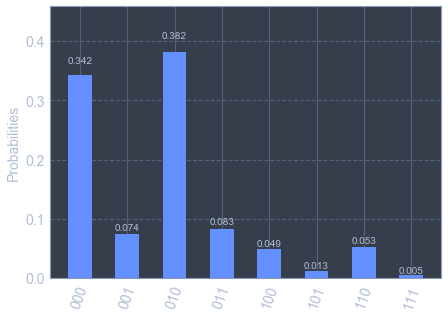

In [8]:
qasm_sim = qiskit.Aer.get_backend("qasm_simulator")
N=1024
results = execute(circ, backend=qasm_sim, shots=N).result()
counts=results.get_counts()
print(counts)
plot_histogram(counts)

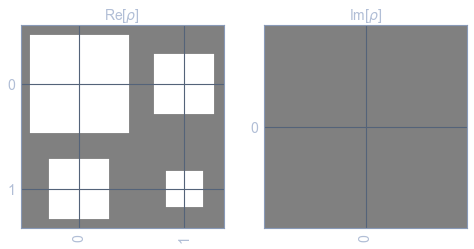

In [49]:
# now we have to make sense of the results:
# counts on the eigenvalues of X operator
x_plus = 0
x_minus = 0
# counts on the eigenvalues of Y operator
y_plus = 0
y_minus = 0
# counts on the eigenvalues of Y operator
z_plus = 0
z_minus = 0

for i in counts:
    if i[-1] == "0":
        x_plus += counts[i]
    elif i[-1] == "1":
        x_minus += counts[i]

    if i[-2] == "0":
        y_plus += counts[i]
    elif i[-2] == "1":
        y_minus += counts[i]

    if i[-3] == "0":
        z_plus += counts[i]
    elif i[-3] == "1":
        z_minus += counts[i]

avgx = (x_plus-x_minus)/N
avgy = (y_plus-y_minus)/N
avgz = (z_plus-z_minus)/N

pauli_x = np.array([[0, 1],
                    [1, 0]], dtype=complex)
pauli_y = np.array([[0, -1j],
                    [1j, 0]], dtype=complex)
pauli_z = np.array([[1, 0],
                    [0, -1]], dtype=complex)
identity = np.array([[1, 0],
                     [0, 1]], dtype=complex)

density = 1/2*(identity+avgx*pauli_x+avgy*pauli_y+avgz*pauli_z)

plot_state_hinton(init_vector)

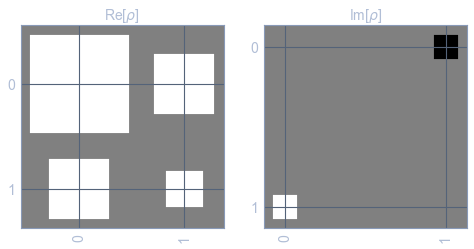

In [50]:
plot_state_hinton(density)

And there you have it. We started from some random initial state vector and were able to approximate it using some measurements. This approximation is as good as the central limit theorem allows it to be, that is, the greater the number of measurements, the better our estimate is. But let's think for a moment: Whenever we build a circuit we know already what our final state is going to be, we know exactly how our gates operate, so how on earth is this useful? In a perfect world, it's not. But we don't live in a perfect world, and our quantum gates will generate errors, and even though our final states can be approximatelly equal to our predictions, there will always be some imperfections. And to make it worse, what if they are sistematic? That is, no matter how many trials of our circuit we do, we still get some unexpected results? By identifing these terms we are able to study the operation of our circuit in a bit more detail. This is of extreme importance for quantum error correction (for "debugging" if you will), and quantum state tomography is a powerful tool for quantum *process* tomography, which is evaluating your circuit as a whole from the input and output. taking this into account, physicists have come up with a measure called "Fidelity" that measures how similar two quantum states are. You can promptly see how useful this can be for evaluating how "Ideal" your circuit is if you compute the fidelity of your predicted state and experimental state.

## Closing remarks


Here we have explored the simplest of all possible cases, the single qubit, but this will never be what we'll be working with, there will generally be dozens of qubits and (who knows?) maybe hundreds of qubits, and from that things get quite complicated, that is why we need very talented people working on this subject. Fortunately there already are and qiskit gives us the module *Ignis* that has some circuits for quantum state and process tomography. I encourage you to explore it a bit.

It's also worth noting that we have made use of te simplest of tomographies on what quantum information is concerned. There are other more efficient techniques that are worth noting:

- Linear Inversion (What we used);
- Linear Regression;
- Maximum likelihood;
- Bayesian methods.

Again, take a look on these methods.

